<a href="https://colab.research.google.com/github/vrublevskiyvitaliy/paraphrase_identification/blob/master/Dependancy_graph_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# All installs here

# Download medium model
!python -m spacy download en_core_web_md

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [0]:
# All imports and installs should be here
import os
import sys

import pandas as pd
import numpy as np
from nltk import wordpunct_tokenize
import operator
import re, string
import math
import spacy
import copy

from nltk import Tree
# Space module import
import en_core_web_md
# NetworkX is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks.
import networkx as nx
from networkx import __version__ as nxv
# linear_sum_assignment Hungarian algorithm
from scipy.optimize import linear_sum_assignment

In [0]:
# All constants

COLAB_ENV = "colab"
LOCAL_ENV = "local"

SENTENCE_START_TOKEN = "sentence_start"
SENTENCE_END_TOKEN = "sentence_end"
UNKNOWN_TOKEN = "unknown_token"


In [0]:
def get_spacy_module():
  return en_core_web_md.load()

In [0]:
# To be able run this notebook from Google Colab and localy

def get_running_env():
  current_path = os.getcwd()
  if current_path == "/content":
    return COLAB_ENV
  return LOCAL_ENV

RUNNING_ENV = get_running_env()

In [0]:
# Supress output of the cell
%%capture
def download_corpus():
    """
      Downloading corpus files for colab research.
    """ 
    if RUNNING_ENV == LOCAL_ENV:
      return
    files = [
      'vrublevskiyvitaliy/paraphrase_identification/contents/dataset/msr-paraphrase-corpus/msr_paraphrase_train.txt',
      'vrublevskiyvitaliy/paraphrase_identification/contents/dataset/msr-paraphrase-corpus/msr_paraphrase_test.txt',
    ]
    for f in files:
       !curl --remote-name \
          -H 'Accept: application/vnd.github.v3.raw' \
          --location https://api.github.com/repos/{f}

download_corpus()

In [0]:
def get_data_location():
  return "" if RUNNING_ENV == COLAB_ENV else "./dataset/msr-paraphrase-corpus/"

def add_start_end_sentence_tokens(s):
  return "%s %s %s" % (SENTENCE_START_TOKEN, s, SENTENCE_END_TOKEN)

def load_data(_preprocess_sentence=None, _train=False, _test=False):
    "Load the MSRP dataset."
    loc = get_data_location()
    trainloc = loc + 'msr_paraphrase_train.txt'
    testloc = loc + 'msr_paraphrase_test.txt'

    if _preprocess_sentence is None:
      _preprocess_sentence = lambda x: x

    sent1_train, sent2_train, sent1_test, sent2_test = [], [], [], []
    label_train, label_dev, label_test = [], [], []

    if _train:
        with open(trainloc, 'r', encoding='utf8') as f:
            f.readline()  # skipping the header of the file
            for line in f:
                text = line.strip().split('\t')
                sent1_train.append(_preprocess_sentence(text[3]))
                sent2_train.append(_preprocess_sentence(text[4]))
                label_train.append(int(text[0]))

    if _test:
        with open(testloc, 'r', encoding='utf8') as f:
            f.readline()  # skipping the header of the file
            for line in f:
                text = line.strip().split('\t')
                sent1_test.append(_preprocess_sentence(text[3]))
                sent2_test.append(_preprocess_sentence(text[4]))
                label_test.append(int(text[0]))

    if _train and _test:
        return [sent1_train, sent2_train], [sent1_test, sent2_test], [label_train, label_test]
    elif _train:
        return [sent1_train, sent2_train], label_train
    elif _test:
        return [sent1_test, sent2_test], label_test

In [0]:
data = load_data(_preprocess_sentence=None, _train=True, _test=False)

In [0]:
def get_sample_data():
  all_data = load_data(_preprocess_sentence=None, _train=True, _test=False)
  return all_data[0][0][0], all_data[0][1][0],  all_data[1][0]

In [10]:
sample = get_sample_data()
sample

('Amrozi accused his brother, whom he called "the witness", of deliberately distorting his evidence.',
 'Referring to him as only "the witness", Amrozi accused his brother of deliberately distorting his evidence.',
 1)

In [0]:
nlp = get_spacy_module()

In [12]:
def get_dependancy_graph(s, display=False):
  doc = nlp(s)
  if display:
    spacy.displacy.render(doc, style="dep", jupyter=True)
  edges = []
  nodes = [{
      "node": "ROOT",
      "token": None,
      "is_fake": True, 
  }]
  for token in doc:
    nodes.append({
        "node": token.text,
        "token": token,
        "is_fake": False,
    })
    if token.dep_ == "ROOT":
      edges.append({
        "start": "ROOT",
        "end": token.text,
        "start_node_id": 0,
        "end_node_id": token.i + 1,
        "type": token.dep_
      })
    else:
      edges.append({
        "start": token.head.text,
        "end": token.text,
        "start_node_id":  token.head.i + 1,
        "end_node_id": token.i + 1,
        "type": token.dep_
      })
  return {"nodes": nodes, "edges": edges}

graph1 = get_dependancy_graph(sample[0], True)
graph2 = get_dependancy_graph(sample[1], True)
print(graph1)
print(graph2)



{'nodes': [{'node': 'ROOT', 'token': None, 'is_fake': True}, {'node': 'Amrozi', 'token': Amrozi, 'is_fake': False}, {'node': 'accused', 'token': accused, 'is_fake': False}, {'node': 'his', 'token': his, 'is_fake': False}, {'node': 'brother', 'token': brother, 'is_fake': False}, {'node': ',', 'token': ,, 'is_fake': False}, {'node': 'whom', 'token': whom, 'is_fake': False}, {'node': 'he', 'token': he, 'is_fake': False}, {'node': 'called', 'token': called, 'is_fake': False}, {'node': '"', 'token': ", 'is_fake': False}, {'node': 'the', 'token': the, 'is_fake': False}, {'node': 'witness', 'token': witness, 'is_fake': False}, {'node': '"', 'token': ", 'is_fake': False}, {'node': ',', 'token': ,, 'is_fake': False}, {'node': 'of', 'token': of, 'is_fake': False}, {'node': 'deliberately', 'token': deliberately, 'is_fake': False}, {'node': 'distorting', 'token': distorting, 'is_fake': False}, {'node': 'his', 'token': his, 'is_fake': False}, {'node': 'evidence', 'token': evidence, 'is_fake': False

Here I try to explore diferent Graph similarity algorithms:

First approach
1.   Map nodes using Hungarian algorithm
2.   Count Graph Edit Distance GED also using Hungarian algorithm



In [0]:
# Code is taken from https://github.com/Jacobe2169/ged4py

class EdgeGraph():
    def __init__(self, init_node, nodes):
        self.init_node=init_node
        self.nodes_ = nodes

    def nodes(self):
        return self.nodes_

    def size(self):
        return len(self.nodes)
    def __len__(self):
        return len(self.nodes_)

class AbstractGraphEditDistance(object):
    def __init__(self, g1, g2):
        self.g1 = g1
        self.g2 = g2

    def normalized_distance(self):
        """
        Returns the graph edit distance between graph g1 & g2
        The distance is normalized on the size of the two graphs.
        This is done to avoid favorisation towards smaller graphs
        """
        avg_graphlen = (len(self.g1) + len(self.g2)) / 2
        return self.distance() / avg_graphlen

    def distance(self):
        return sum(self.edit_costs())

    def edit_costs(self):
        cost_matrix = self.create_cost_matrix()
        row_ind,col_ind = linear_sum_assignment(cost_matrix)
        return [cost_matrix[row_ind[i]][col_ind[i]] for i in range(len(row_ind))]

    def create_cost_matrix(self):
        """
        Creates a |N+M| X |N+M| cost matrix between all nodes in
        graphs g1 and g2
        Each cost represents the cost of substituting,
        deleting or inserting a node
        The cost matrix consists of four regions:
        substitute 	| insert costs
        -------------------------------
        delete 		| delete -> delete
        The delete -> delete region is filled with zeros
        """
        n = len(self.g1)
        m = len(self.g2)
        cost_matrix = np.zeros((n+m,n+m))
        #cost_matrix = [[0 for i in range(n + m)] for j in range(n + m)]
        nodes1 = self.g1.nodes() if float(nxv) < 2 else list(self.g1.nodes())
        nodes2 = self.g2.nodes() if float(nxv) < 2 else list(self.g2.nodes())

        for i in range(n):
            for j in range(m):
                cost_matrix[i,j] = self.substitute_cost(nodes1[i], nodes2[j])

        for i in range(m):
            for j in range(m):
                cost_matrix[i+n,j] = self.insert_cost(i, j, nodes2)

        for i in range(n):
            for j in range(n):
                cost_matrix[j,i+m] = self.delete_cost(i, j, nodes1)

        self.cost_matrix = cost_matrix
        return cost_matrix

    def insert_cost(self, i, j):
        raise NotImplementedError

    def delete_cost(self, i, j):
        raise NotImplementedError

    def substitute_cost(self, nodes1, nodes2):
        raise NotImplementedError

    def print_matrix(self):
        print("cost matrix:")
        for column in self.create_cost_matrix():
            for row in column:
                if row == sys.maxsize:
                    print ("inf\t")
                else:
                    print ("%.2f\t" % float(row))
            print("")

class EdgeEditDistance(AbstractGraphEditDistance):
    """
    Calculates the graph edit distance between two edges.
    A node in this context is interpreted as a graph,
    and edges are interpreted as nodes.
    """

    def __init__(self, g1, g2):
        AbstractGraphEditDistance.__init__(self, g1, g2)

    def insert_cost(self, i, j, nodes2):
        if i == j:
            return 1
        return sys.maxsize

    def delete_cost(self, i, j, nodes1):
        if i == j:
            return 1
        return sys.maxsize

    def substitute_cost(self, edge1, edge2):
        if edge1 == edge2:
            return 0.
        return 1

class GraphEditDistance(AbstractGraphEditDistance):
    def __init__(self, g1, g2):
        AbstractGraphEditDistance.__init__(self, g1, g2)

    def substitute_cost(self, node1, node2):
        return self.relabel_cost(node1, node2) + self.edge_diff(node1, node2)

    def relabel_cost(self, node1, node2):
        if node1 == node2:
            return 0.
        else:
            return 1.

    def delete_cost(self, i, j, nodes1):
        if i == j:
            return 1
        return sys.maxsize

    def insert_cost(self, i, j, nodes2):
        if i == j:
            return 1
        else:
            return sys.maxsize

    def pos_insdel_weight(self, node):
        return 1

    def edge_diff(self, node1, node2):
        edges1 = list(self.g1.edge[node1].keys()) if float(nxv) < 2 else list(self.g1.edges(node1))
        edges2 = list(self.g2.edge[node2].keys()) if float(nxv) < 2 else list(self.g2.edges(node2))
        if len(edges1) == 0 or len(edges2) == 0:
            return max(len(edges1), len(edges2))

        edit_edit_dist = EdgeEditDistance(EdgeGraph(node1,edges1), EdgeGraph(node2,edges2))
        return edit_edit_dist.normalized_distance()

def compare_graphs(g1, g2, print_details=False):
    ged = GraphEditDistance(g1, g2)

    if print_details:
        ged.print_matrix()

    #return ged.normalized_distance()
    return ged.distance()


In [0]:
class HungarianGraphNodesMatcher:

  def __init__(self, _g1, _g2):
    self.g1 = _g1
    self.g2 = _g2
    self.create_cost_matrix()
    self.match_nodes()

  def create_cost_matrix(self):
    self.matrix = np.zeros((len(self.g1["nodes"]), len(self.g2["nodes"])))
    for i1, n1 in enumerate(self.g1["nodes"]):
       for i2, n2 in enumerate(self.g2["nodes"]):
         if not n1["is_fake"] and not n2["is_fake"]:
           self.matrix[i1][i2] = n1["token"].similarity(n2["token"])
         elif n1["is_fake"] and n2["is_fake"]:
           self.matrix[i1][i2] = n1["node"] == n2["node"]
         else:
           self.matrix[i1][i2] = 0

    # Now we need to fleep scores, because Hungarian is trying to minimize
    self.matrix = np.subtract(np.full(self.matrix.shape, 1), self.matrix)

  def get_pandas_matrix(self):
    df = pd.DataFrame(
        data=self.matrix,
        index=np.array([n["node"] for n in self.g1["nodes"]]),
        columns=np.array([n["node"] for n in self.g2["nodes"]])
      )
    
    return df

  def match_nodes(self):
    row_ind, col_ind = linear_sum_assignment(self.matrix)

    self.graph1_to_graph2 = {
        n1: n2 for n1, n2 in enumerate(col_ind)
    }
    self.row_ind = row_ind
    self.col_ind = col_ind

  def create_node_aliases(self):
    for id1, n1 in enumerate(self.g1["nodes"]):
      n1["alias"] = "G1_" + str(id1) + n1["node"]
    for id2, n2 in enumerate(self.g2["nodes"]):
      n2["alias"] = "G2_" + str(id2) + n2["node"] 
    for id1, id2 in self.graph1_to_graph2.items():
      n1 = self.g1["nodes"][id1]
      n2 = self.g2["nodes"][id2]
      n1["alias"] = "G1_" + str(id1) + "_" + n1["node"] + "_G2_" + str(id2) + "_" + n2["node"]
      n2["alias"] = n1["alias"]

  def build_graph(self, g):
    nx_g = nx.Graph()
    for edge1 in g["edges"]:
      start_node = g["nodes"][edge1["start_node_id"]]
      end_node = g["nodes"][edge1["end_node_id"]]
      nx_g.add_edge(start_node["alias"], end_node["alias"])
    return nx_g

  def get_converted_graphs(self):
    self.create_node_aliases()
    g1 = self.build_graph(self.g1)
    g2 = self.build_graph(self.g2)
    return g1, g2

  def print_matched_nodes(self):
    print ("Graph 1  =>   Graph 2")
    for id1, id2 in self.graph1_to_graph2.items():
      print(f"{self.g1['nodes'][id1]['node']}    =>   {self.g2['nodes'][id2]['node']}")

In [0]:
# Supress output of the cell
%%capture
node_matcher = HungarianGraphNodesMatcher(graph1, graph2)


In [28]:
df = node_matcher.get_pandas_matrix()

df

,ROOT,Referring,to,him,as,only,"""",the,witness,"""",",",Amrozi,accused,his,brother,of,deliberately,distorting,his,evidence,.
ROOT,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Amrozi,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
accused,1.0,0.537212,0.752698,0.571157,0.670279,0.711298,0.822630,0.754388,0.504037,0.822630,0.845226,1.0,0.000000,0.590191,0.569683,0.754245,0.507848,0.837679,0.590191,0.544300,0.910306
his,1.0,0.551127,0.549901,0.181684,0.465709,0.540010,0.692279,0.410963,0.539461,0.692279,0.752804,1.0,0.590191,0.000000,0.404898,0.529692,0.624516,0.751290,0.000000,0.627589,0.706742
brother,1.0,0.673135,0.721060,0.406448,0.640046,0.684511,0.834577,0.723350,0.617876,0.834577,0.739446,1.0,0.569683,0.404898,0.000000,0.781704,0.797187,0.908400,0.404898,0.818612,0.755431
",",1.0,0.808523,0.739116,0.739543,0.546560,0.727806,0.774776,0.792215,0.795072,0.774776,0.000000,1.0,0.845226,0.752804,0.739446,0.753711,0.821649,0.884728,0.752804,0.781733,0.578476
whom,1.0,0.469382,0.595635,0.372705,0.472646,0.491974,0.805766,0.624194,0.508752,0.805766,0.766535,1.0,0.496651,0.456207,0.438194,0.637548,0.597901,0.876076,0.456207,0.608186,0.777147
he,1.0,0.498411,0.563380,0.172480,0.407789,0.422754,0.627206,0.508185,0.523701,0.627206,0.649141,1.0,0.545751,0.208112,0.420867,0.625115,0.544173,0.789522,0.208112,0.582609,0.580044
called,1.0,0.496763,0.642630,0.582938,0.441778,0.598515,0.551076,0.467194,0.730760,0.551076,0.793144,1.0,0.686286,0.590765,0.677895,0.598167,0.753492,0.891696,0.590765,0.704837,0.748416
"""",1.0,0.685711,0.700709,0.695448,0.641444,0.722364,0.000000,0.700664,0.807665,0.000000,0.774776,1.0,0.822630,0.692279,0.834577,0.762673,0.797517,0.880281,0.692279,0.790533,0.707590


In [30]:
node_matcher.print_matched_nodes()
g1, g2 = node_matcher.get_converted_graphs()
score = compare_graphs(g1, g2)
print(f"Similarity score {score}")

Graph 1  =>   Graph 2
ROOT    =>   ROOT
Amrozi    =>   Amrozi
accused    =>   accused
his    =>   his
brother    =>   brother
,    =>   ,
whom    =>   only
he    =>   him
called    =>   Referring
"    =>   "
the    =>   the
witness    =>   witness
"    =>   "
,    =>   as
of    =>   of
deliberately    =>   deliberately
distorting    =>   distorting
his    =>   his
evidence    =>   evidence
.    =>   .
Similarity score 0.5939873134995086


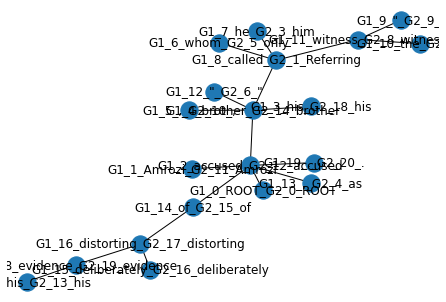

In [31]:
nx.draw(g1, with_labels=True)

In [0]:
# Supress output of the cell
%%capture

def calculate_scores(limit=10):
  result = []
  for i in range(limit):
    s1 = data[0][0][i]
    s2 = data[0][1][i]
    label = data[1][i]
    graph1 = get_dependancy_graph(s1, False)
    graph2 = get_dependancy_graph(s2, False)
    node_matcher = HungarianGraphNodesMatcher(graph1, graph2)
    g1, g2 = node_matcher.get_converted_graphs()
    score = compare_graphs(g1, g2)
    result.append((s1, s2, label, score))
  return result



result = calculate_scores()


In [46]:
for d in result:
  print (f"Label {d[2]}    |   Score {d[3]}")

Label 1    |   Score 12.176739926739927
Label 0    |   Score 11.34871794871795
Label 1    |   Score 8.841666666666667
Label 0    |   Score 33.480952380952374
Label 1    |   Score 25.78333333333333
Label 1    |   Score 18.065151515151513
Label 0    |   Score 19.28205128205128
Label 1    |   Score 2.819047619047619
Label 0    |   Score 20.25873015873016
Label 1    |   Score 22.083333333333332


Ideas to try:
* add treshold for node matching, only if > 0.5 for example merge nodes